In [686]:
import numpy as np
import string
import matplotlib.pyplot as plt


In [687]:
import seaborn as sns
import random

In [688]:
def generate_almost_orthogonal_embeddings(k, D, seed=42):
    rng = np.random.default_rng(seed)
    vecs = rng.normal(size=(k, D))
    # Normalisation
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
    return vecs.astype(np.float32)


In [689]:
def orthogonality_score(embeddings):
    dot_prods = embeddings @ embeddings.T
    np.fill_diagonal(dot_prods, 0)
    return np.max(np.abs(dot_prods))


In [690]:
R = 20

In [691]:
T = 20
k = 26
D = 500

In [692]:
embeddings = generate_almost_orthogonal_embeddings(1+k+T, D//2, seed=0)

In [693]:
def generate_dict(k, D):
    assert D % 2 == 0, "D doit être divisible par 2"
    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}

    # Ajout du token 'b' (begin)
    begin_half = embeddings[0]
    begin_vec = np.concatenate([begin_half, np.zeros(D // 2, dtype=np.float32)])
    dico['b'] = begin_vec

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        half = embeddings[i + 1]
        vec = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])
        dico[key] = vec

    return dico

In [694]:
dic = generate_dict(k, D)

In [695]:
dic['C'] @ dic['C'].T

1.0

In [696]:
def string_to_token(s):
    return np.array([dic[c] for c in s]).astype(np.float32)

In [697]:
def softmax(x, axis=None):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

In [698]:

string_seq = ['b', 'C', 'A', 'D', 'C', 'D', 'E', 'A', 'A', 'D', 'B', 'E']
T = len(string_seq)

In [699]:
P = np.zeros((T, D), dtype=np.float32)
for i in range(T):
    half = embeddings[k + i + 1]
    P[i] = np.concatenate([half, np.zeros(D // 2, dtype=np.float32)])

In [700]:
P.shape

(12, 500)

In [701]:
P[0] @ P[1].T

0.023900952

In [702]:
def permutation_matrix(D):
    assert D % 2 == 0, "D doit être pair"
    d_half = D // 2
    V = np.zeros((D, D))

    # Remplit les blocs pour permuter les deux moitiés
    V[:d_half, d_half:] = np.eye(d_half)  # Haut droit
    V[d_half:, :d_half] = np.eye(d_half)  # Bas gauche

    return V

In [703]:
def embedding(P, S):
    T = S.shape[0]
    return P[:T,:]+S

In [704]:
def first_layer(P, S):
    X = embedding(P, S)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    
    Att = X @ QK1 @ (X.T)/ np.linalg.norm(X @ QK1 @ (X.T)) * 20
    Att = softmax(Att, axis=1)
    V = permutation_matrix(D)
    Z = (Att @ X @ V)/np.linalg.norm(Att @ X @ V)+X/np.linalg.norm(X)
    return Att, Z

In [705]:
Att1, Z1 = first_layer(P, string_to_token(string_seq))
Z1

array([[-0.00056303, -0.00207355,  0.00647514, ...,  0.02265752,
        -0.00755064, -0.00711505],
       [ 0.03334473,  0.02053886,  0.02350675, ...,  0.02677406,
         0.00190065, -0.0203285 ],
       [ 0.01473123,  0.0209976 ,  0.02754828, ...,  0.00761032,
         0.00307436, -0.00831785],
       ...,
       [-0.00027133,  0.01291881,  0.00502987, ...,  0.00065864,
        -0.02211798, -0.01564801],
       [ 0.01641016, -0.00223529, -0.00416616, ...,  0.04150658,
         0.01173761, -0.00510874],
       [ 0.02424448, -0.01699262,  0.0044903 , ..., -0.01140902,
         0.01633344,  0.00264174]])

In [706]:
def display_matrix(Att, string_seq):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Att, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=string_seq, yticklabels=string_seq)
    plt.title("Attention Matrix")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.show()


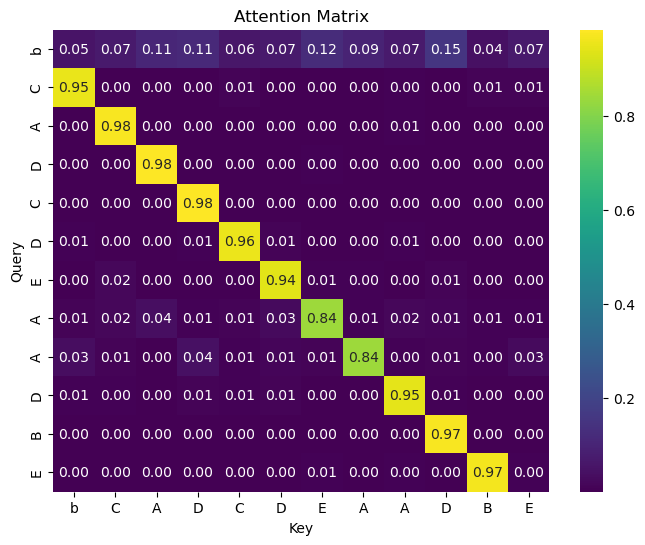

In [707]:
display_matrix(Att1, string_seq)

In [708]:
R = D//2

In [709]:
def second_layer(Z, beta=1):
    K_2 = np.zeros((D, D), dtype=np.float32)
    #K_2[:D//2, D//2:] = np.eye(D//2)  
    K_2[:R, D//2:D//2+R] = np.eye(R)  
    Att2 = Z @(K_2) @ (Z.T) *100
    Att2 = softmax(Att2, axis=1)
    V2 = beta* np.eye(D)
    Z2 = (Att2 @ Z @ V2)/np.linalg.norm(Att2 @ Z)
    return Att2, Z2


In [710]:
Att2, Z2 = second_layer(Z1)

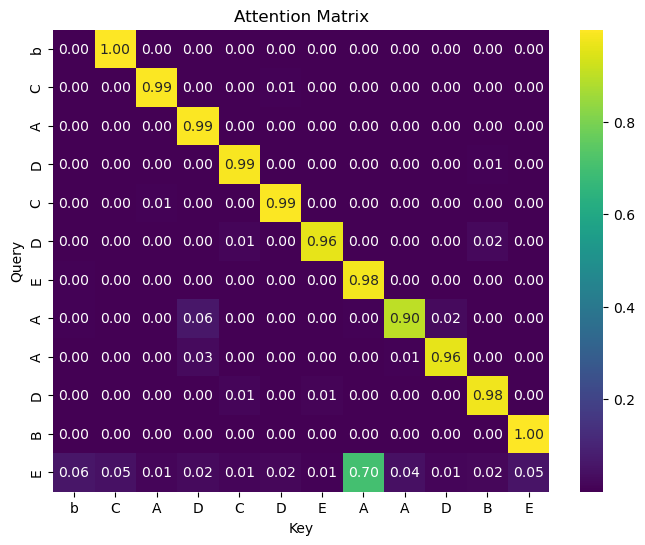

In [711]:
display_matrix(Att2, string_seq)

In [712]:
def classification(k, dico, Z):
    mlp = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        mlp[i] = dico[key] *30
    logits = mlp @ Z[-1].T
    return softmax(logits)
    

In [713]:
classification_result = classification(k, dic, Z2)
print("Classification result", classification_result)

Classification result [0.36039499 0.01579907 0.023797   0.0234687  0.06694163 0.02439889
 0.02008325 0.01960405 0.02746076 0.03815999 0.01598639 0.02542586
 0.0286148  0.03040487 0.02191852 0.02872321 0.01614777 0.03688301
 0.02379578 0.01966464 0.01724111 0.02755713 0.02093638 0.01986568
 0.02300192 0.02372462]


In [714]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

def plot_output(output, k):
    letters = list(string.ascii_uppercase[:k])
    df = pd.DataFrame({'Lettre': letters, 'Probabilité': output})

    plt.figure(figsize=(8, 4))
    sns.barplot(data=df, x='Lettre', y='Probabilité')
    plt.title("Distribution des probabilités (softmax)")
    plt.ylim(0, 1)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()


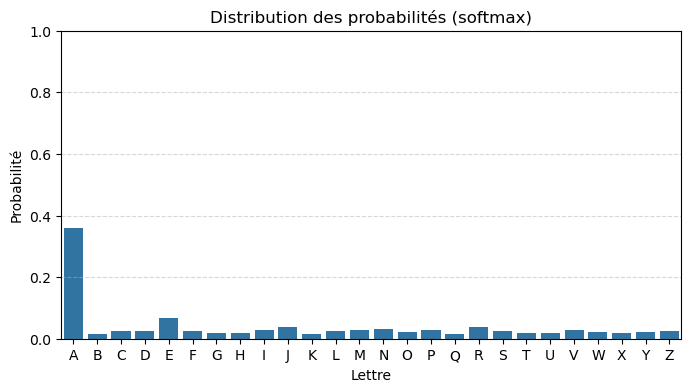

In [715]:
plot_output(classification_result, k)

In [716]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = []
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(0, T - 2)

        middle_letters = []
        for i in range(0, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos+1]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [717]:
X, y = generate_X_y(T, dic, 1)
X, y

([['K', 'B', 'B', 'A', 'C', 'F', 'X', 'Q', 'T', 'U', 'Z', 'O', 'T']], ['U'])

In [718]:
def model(S):
    Att1, Z1 = first_layer(P, S)
    Att2, Z2 = second_layer(Z1)
    logits = classification(k, dic, Z2)
    return logits

In [719]:
P.shape, string_to_token(string_seq).shape

((12, 500), (12, 500))

In [720]:
model(string_to_token(string_seq))

array([0.36039499, 0.01579907, 0.023797  , 0.0234687 , 0.06694163,
       0.02439889, 0.02008325, 0.01960405, 0.02746076, 0.03815999,
       0.01598639, 0.02542586, 0.0286148 , 0.03040487, 0.02191852,
       0.02872321, 0.01614777, 0.03688301, 0.02379578, 0.01966464,
       0.01724111, 0.02755713, 0.02093638, 0.01986568, 0.02300192,
       0.02372462])

In [721]:
import numpy as np

def display_predictions_numpy(X_seq, y_true, model, char_to_int, int_to_char):
    """
    X_seq : liste de séquences de lettres (n x (T+1))
    y_true : liste de lettres (n)
    model  : fonction prenant S (n, T+1) indices → logits (n, k)
    Retourne l'affichage coloré dans le terminal.
    """
    error = 0
    BLUE  = '\033[94m'
    GREEN = '\033[92m'
    RESET = '\033[0m'

    # Conversion une fois des séquences en indices
    S_list = [string_to_token(x) for x in X_seq]  # shape (n, T+1)

    for i, S in enumerate(S_list):
        logits = model(S)             # shape (1, k) ou (k,)
        # si model renvoie (1,k), on aplatit :
        logits = logits.flatten()
        y_pred_idx = np.argmax(logits)
        pred_letter = int_to_char[y_pred_idx+1]
        true_letter = y_true[i]

        x_letters = X_seq[i]
        last = x_letters[-1]
        # trouver position unique de last dans le préfixe (sans compter b)
        other_pos = next(j for j, c in enumerate(x_letters[0:-1], start=0) if c == last)

        # marquer la séquence
        colored = []
        for j, c in enumerate(x_letters[1:], start=1):  # on ignore le 'b' à j=0
            if j == other_pos or j == len(x_letters)-1:
                # soit la première occurrence du last, soit la dernière
                colored.append(f"{BLUE}{c}{RESET}")
            elif c == true_letter:
                colored.append(f"{GREEN}{c}{RESET}")
            else:
                colored.append(c)

        print(f"Sequence : {''.join(colored)}")
        print(f"  True : {GREEN}{true_letter}{RESET}, Predicted : {GREEN}{pred_letter}{RESET}")

        # compter les erreurs
        if logits.max() < 0.5 or pred_letter != true_letter:
            error += 1

    print(f"\nErreur : {error} / {len(X_seq)} séquences")


In [722]:
T=10
X_seq, y = generate_X_y(T=T, dico=dic, n=30)


In [723]:
char_to_int = {c: i for i, c in enumerate(dic)}
int_to_char = {i: c for c, i in char_to_int.items()}


display_predictions_numpy(X_seq[:30], y, model, char_to_int, int_to_char)


Sequence : KXXNJWFFPK
  True : X, Predicted : X
Sequence : EPTHLVIIGH
  True : L, Predicted : L
Sequence : FFDRYZEBYR
  True : Y, Predicted : Y
Sequence : FHJLQBOMCF
  True : H, Predicted : H
Sequence : VEXYVRSAKE
  True : X, Predicted : X
Sequence : OLHSRHREDO
  True : L, Predicted : L
Sequence : DFSGXVSDXG
  True : X, Predicted : X
Sequence : LFBFUEMEKB
  True : F, Predicted : F
Sequence : YFIIDIIVJM
  True : Y, Predicted : Y
Sequence : CEYXZQSJPZ
  True : Q, Predicted : Q
Sequence : QILKFUDAKD
  True : A, Predicted : A
Sequence : RAYGMHETFG
  True : M, Predicted : M
Sequence : NHJYOSZRPO
  True : S, Predicted : S
Sequence : CWTIEBFGPG
  True : P, Predicted : P
Sequence : BFWMQRPWHP
  True : W, Predicted : W
Sequence : SEJBTEUMOB
  True : T, Predicted : T
Sequence : GGYCVAPJBV
  True : A, Predicted : A
Sequence : IZVZABWIMW
  True : I, Predicted : I
Sequence : ZDTXICMOTD
  True : T, Predicted : T
Sequence : VBNDPWSHYS
  True : H, Predicted : H
Sequence : NUZJTFAABJ
  True : T, Predic

In [724]:
X_seq, y = generate_X_y(T=T, dico=dic, n=20000)

In [725]:
X_token = [string_to_token(x) for x in X_seq]  # shape (n, T+1)
X_token = np.array(X_token, dtype=np.float32)  # shape (n, T+1, D)
X_token.shape, X_token.dtype

((20000, 11, 500), dtype('float32'))

In [726]:
y_data = np.array([char_to_int[c]-1 for c in y], dtype=np.int32)  # shape (n,)
y_data

array([13, 22, 14, ..., 19, 20,  5], dtype=int32)

In [727]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn

In [728]:

class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.beta = nn.Parameter(torch.ones(1))
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = self.beta * torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)
class AttentionOnlyTransformer(nn.Module):
    def __init__(self, d_model=2000, nhead=1, num_layers=2, num_classes=26, max_len=11):
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, d_model))
        self.blocks = nn.ModuleList([
            AttentionOnlyBlock(d_model) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes, bias=False)

    def forward(self, x):  # x: (B, T, D)
        x = x + self.positional_encoding[:, :x.size(1), :]
        for block in self.blocks:
            x = block(x)
        last_token = x[:, -1, :]  # utiliser la sortie du dernier token
        return self.classifier(last_token)  # (B, num_classes)


In [729]:
X_tensor = torch.tensor(X_token, dtype=torch.float32)  # (30, 11, 2000)
y_tensor = torch.tensor(y_data, dtype=torch.long)  

In [730]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=320, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [731]:
def initialize_model(model):
    # classifier
    classifier_layer = np.zeros((k, D), dtype=np.float32)
    letters = list(string.ascii_uppercase)
    for i in range(k):
        key = letters[i]
        classifier_layer[i] = dic[key]
    with torch.no_grad():
        model.classifier.weight.copy_(torch.tensor(classifier_layer, dtype=torch.float32))
        model.classifier.weight.requires_grad = False

    # first layer
    P_copy = P[:T+1].copy()
    V1 = permutation_matrix(D)  
    attn_layer1 = model.blocks[0]
    W_k1 = np.eye(D, dtype=np.float32)
    W_v1 = V1.astype(np.float32)
    QK1 = np.zeros((D,D), dtype=np.float32)
    for i in range(1, len(P)):
        QK1 = QK1 + (P[i].reshape(D, 1) @ P[i-1].reshape(1, D))
    W_q1 = QK1.astype(np.float32).T *100
    with torch.no_grad():
        #attn_layer1.Wq.weight.data.copy_(torch.tensor(W_q1))
        attn_layer1.Wk.weight.data.copy_(torch.tensor(W_k1))
        attn_layer1.Wv.weight.data.copy_(torch.tensor(W_v1))
        attn_layer1.Wv.weight.requires_grad = False
        #attn_layer1.Wq.weight.requires_grad = False
        attn_layer1.Wk.weight.requires_grad = False
    
    # second layer
    K_2 = np.zeros((D, D), dtype=np.float32)
    #K_2[:D//2, D//2:] = np.eye(D//2)  
    K_2[:R, D//2:D//2+R] = np.eye(R)
    K_2 = K_2.astype(np.float32)
    Q_2 = np.eye(D, dtype=np.float32)
    V2 = np.eye(D, dtype=np.float32)
    attn_layer2 = model.blocks[1]
    W_q2 = Q_2.astype(np.float32)
    W_k2 = K_2.astype(np.float32)
    W_v2 = V2.astype(np.float32)
    with torch.no_grad():
        attn_layer2.Wq.weight.data.copy_(torch.tensor(W_q2))
        #attn_layer2.Wk.weight.data.copy_(torch.tensor(W_k2))
        attn_layer2.Wv.weight.data.copy_(torch.tensor(W_v2))
        attn_layer2.Wv.weight.requires_grad = False
        attn_layer2.Wq.weight.requires_grad = False
        #attn_layer2.Wk.weight.requires_grad = False
    
    # positionnal encoding
    with torch.no_grad():
        # Initialiser les poids de la couche d'attention avec P_copy
        model.positional_encoding.copy_(torch.tensor(P_copy.reshape(1, T+1, D), dtype=torch.float32))
        model.positional_encoding.requires_grad = False

    # beta
    with torch.no_grad():
        model.blocks[0].beta.copy_(torch.tensor(1.0, dtype=torch.float32))
        model.blocks[1].beta.copy_(torch.tensor(1.31, dtype=torch.float32))
        model.blocks[0].beta.requires_grad = False
        model.blocks[1].beta.requires_grad = False

    #printing the model parameters
    for name, param in model.named_parameters():
        if param.requires_grad:...
            #print(name, param.shape)


In [732]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_attention_weights(model, layer_idx=0):
    block = model.blocks[layer_idx]
    Wq = block.Wq.weight.detach().cpu().numpy()
    Wk = block.Wk.weight.detach().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(Wq, ax=axes[0], cmap='viridis')
    axes[0].set_title(f'Wq (Layer {layer_idx})')
    axes[0].set_xlabel('Input dimension')
    axes[0].set_ylabel('Output dimension')

    sns.heatmap(Wk, ax=axes[1], cmap='viridis')
    axes[1].set_title(f'Wk (Layer {layer_idx})')
    axes[1].set_xlabel('Input dimension')
    axes[1].set_ylabel('Output dimension')

    plt.tight_layout()
    plt.show()


In [733]:
model = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)


In [734]:
initialize_model(model)

In [735]:
from torch.utils.data import Subset

def get_subset_dataset(train_dataset, D, alpha, shuffle=True):
    num_samples = int(D * alpha)
    print(f"Num samples: {num_samples}")
    indices = torch.randperm(len(train_dataset))[:num_samples] if shuffle else torch.arange(num_samples)
    subset = Subset(train_dataset, indices)
    return subset


In [736]:
import time

In [737]:
def train_model(model, train_loader, criterion, optimizer, D, alpha, num_epochs=10):
    train_subdataset = get_subset_dataset(train_loader.dataset, D, alpha)
    train_loader = DataLoader(train_subdataset, batch_size=320, shuffle=True)
    print(len(train_loader))
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        correct = 0
        total = 0
        # ---------- Entraînement ----------
        train_time = time.time()

        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)  # (B, 27)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            correct += (outputs.argmax(dim=1) == yb).sum().item()
            total += xb.size(0)

        train_acc = correct / total
        train_loss = total_loss / total
        train_time = time.time() - train_time
        #print(f"Training time: {train_time:.2f} seconds")

        # ---------- Évaluation ----------
        model.eval()
        test_time = time.time()
        with torch.no_grad():
            xb, yb = next(iter(test_loader))
            outputs = model(xb)
            test_loss = criterion(outputs, yb).item()
            test_acc = (outputs.argmax(dim=1) == yb).float().mean().item()
        test_time = time.time() - test_time
        #print(f"Test time: {test_time:.2f} seconds")
        if epoch % (num_epochs//50) == 0:
            print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
            #print(f"Beta : {model.blocks[1].beta.item()}")
    return model, train_loss, train_acc, test_acc


In [738]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [740]:
train_model(model, train_loader, criterion, optimizer, D=D, alpha=5, num_epochs=150)

Num samples: 2500
8
Epoch 00 | Train Loss: 5.1323 | Train Acc: 0.0936 | Test Acc: 0.0200
Epoch 03 | Train Loss: 4.5787 | Train Acc: 0.1176 | Test Acc: 0.0000
Epoch 06 | Train Loss: 4.1664 | Train Acc: 0.1292 | Test Acc: 0.0100
Epoch 09 | Train Loss: 3.8435 | Train Acc: 0.1460 | Test Acc: 0.0400
Epoch 12 | Train Loss: 3.5986 | Train Acc: 0.1604 | Test Acc: 0.0300
Epoch 15 | Train Loss: 3.3557 | Train Acc: 0.1856 | Test Acc: 0.0400
Epoch 18 | Train Loss: 3.1734 | Train Acc: 0.2080 | Test Acc: 0.0400
Epoch 21 | Train Loss: 3.0129 | Train Acc: 0.2284 | Test Acc: 0.0400
Epoch 24 | Train Loss: 2.8424 | Train Acc: 0.2672 | Test Acc: 0.0400
Epoch 27 | Train Loss: 2.6939 | Train Acc: 0.2912 | Test Acc: 0.0600
Epoch 30 | Train Loss: 2.5672 | Train Acc: 0.3224 | Test Acc: 0.0900
Epoch 33 | Train Loss: 2.4470 | Train Acc: 0.3484 | Test Acc: 0.0900
Epoch 36 | Train Loss: 2.3269 | Train Acc: 0.3820 | Test Acc: 0.1000
Epoch 39 | Train Loss: 2.2011 | Train Acc: 0.4228 | Test Acc: 0.1200
Epoch 42 | Tra

(AttentionOnlyTransformer(
   (blocks): ModuleList(
     (0-1): 2 x AttentionOnlyBlock(
       (Wq): Linear(in_features=500, out_features=500, bias=False)
       (Wk): Linear(in_features=500, out_features=500, bias=False)
       (Wv): Linear(in_features=500, out_features=500, bias=False)
       (norm): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
     )
   )
   (classifier): Linear(in_features=500, out_features=26, bias=False)
 ),
 0.1799903017282486,
 1.0,
 0.9700000286102295)

In [ ]:
def experiment(alphas):
    results = []
    for a in alphas:
        alpha = a*2
        print(f"Experiment with alpha: {alpha}")
        model = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        initialize_model(model)
        model, train_loss, train_acc, test_acc = train_model(model, train_loader, criterion, optimizer, D=D, alpha=alpha, num_epochs=int(25/alpha+50))
        results.append((alpha, model, train_loss, train_acc, test_acc))
    return results

In [ ]:
alphas = [0.005, 0.01, 0.02, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 4]
results = experiment(alphas)

Experiment with alpha: 0.01
Num samples: 5
1
Epoch 00 | Train Loss: 10.4863 | Train Acc: 0.0000 | Test Acc: 0.0000
Epoch 51 | Train Loss: 0.0259 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 102 | Train Loss: 0.0179 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 153 | Train Loss: 0.0128 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 204 | Train Loss: 0.0096 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 255 | Train Loss: 0.0075 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 306 | Train Loss: 0.0060 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 357 | Train Loss: 0.0049 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 408 | Train Loss: 0.0041 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 459 | Train Loss: 0.0035 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 510 | Train Loss: 0.0030 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 561 | Train Loss: 0.0026 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 612 | Train Loss: 0.0023 | Train Acc: 1.0000 | Test Acc: 0.1200
Epoch 663 | Train Loss: 0.0021 | Train Acc: 1.

KeyboardInterrupt: 

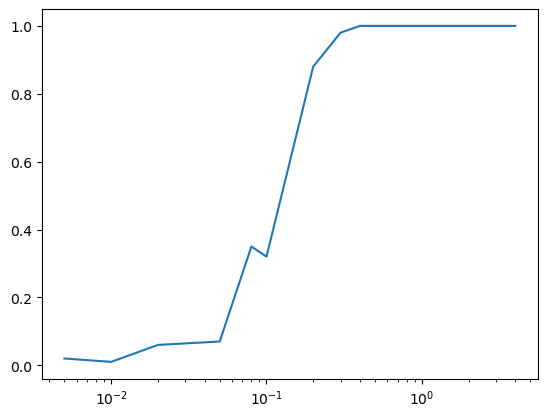

In [ ]:
plt.plot(alphas, [r[4] for r in results], label='Test accuracy')
# log x axis
plt.xscale('log')

In [ ]:
# save model weights
torch.save(model.state_dict(), "model_weights.pth")

In [ ]:
model_saved = AttentionOnlyTransformer(d_model=D, nhead=1, num_layers=2, num_classes=k, max_len=T+1)
model_saved.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

In [744]:
begin = 4
end = 10
X_plot = X_tensor[:end, begin:]
y_plot = y_tensor[:end]

In [ ]:
print(X_plot.shape, y_plot.shape)
print(X_tensor.shape, y_tensor.shape)

torch.Size([10, 9, 500]) torch.Size([10])
torch.Size([20000, 11, 500]) torch.Size([20000])


len:7
Sequence : ['W', 'H', 'N', 'V', 'O', 'U', 'G', 'Y', 'S', 'N', 'S']
  True : N, Predicted : N
0 0
0 1
len:7
Sequence : ['S', 'M', 'R', 'Q', 'W', 'I', 'D', 'G', 'R', 'U', 'Q']
  True : W, Predicted : G
1 0
1 1
len:7
Sequence : ['U', 'V', 'O', 'O', 'G', 'F', 'Z', 'U', 'Z', 'S', 'V']
  True : O, Predicted : U
2 0
2 1
len:7
Sequence : ['V', 'A', 'S', 'K', 'D', 'M', 'L', 'N', 'D', 'V', 'K']
  True : D, Predicted : K
3 0
3 1
len:7
Sequence : ['G', 'G', 'H', 'O', 'K', 'S', 'H', 'P', 'B', 'R', 'K']
  True : S, Predicted : S
4 0
4 1
len:7
Sequence : ['S', 'C', 'Q', 'H', 'Q', 'P', 'M', 'S', 'V', 'O', 'P']
  True : M, Predicted : M
5 0
5 1
len:7
Sequence : ['S', 'U', 'M', 'O', 'A', 'E', 'Y', 'Q', 'G', 'D', 'G']
  True : D, Predicted : D
6 0
6 1
len:7
Sequence : ['M', 'W', 'G', 'A', 'V', 'H', 'S', 'F', 'W', 'U', 'A']
  True : V, Predicted : U
7 0
7 1
len:7
Sequence : ['K', 'E', 'O', 'G', 'E', 'I', 'G', 'Y', 'F', 'H', 'K']
  True : E, Predicted : K
8 0
8 1
len:7
Sequence : ['P', 'D', 'X', 'A',

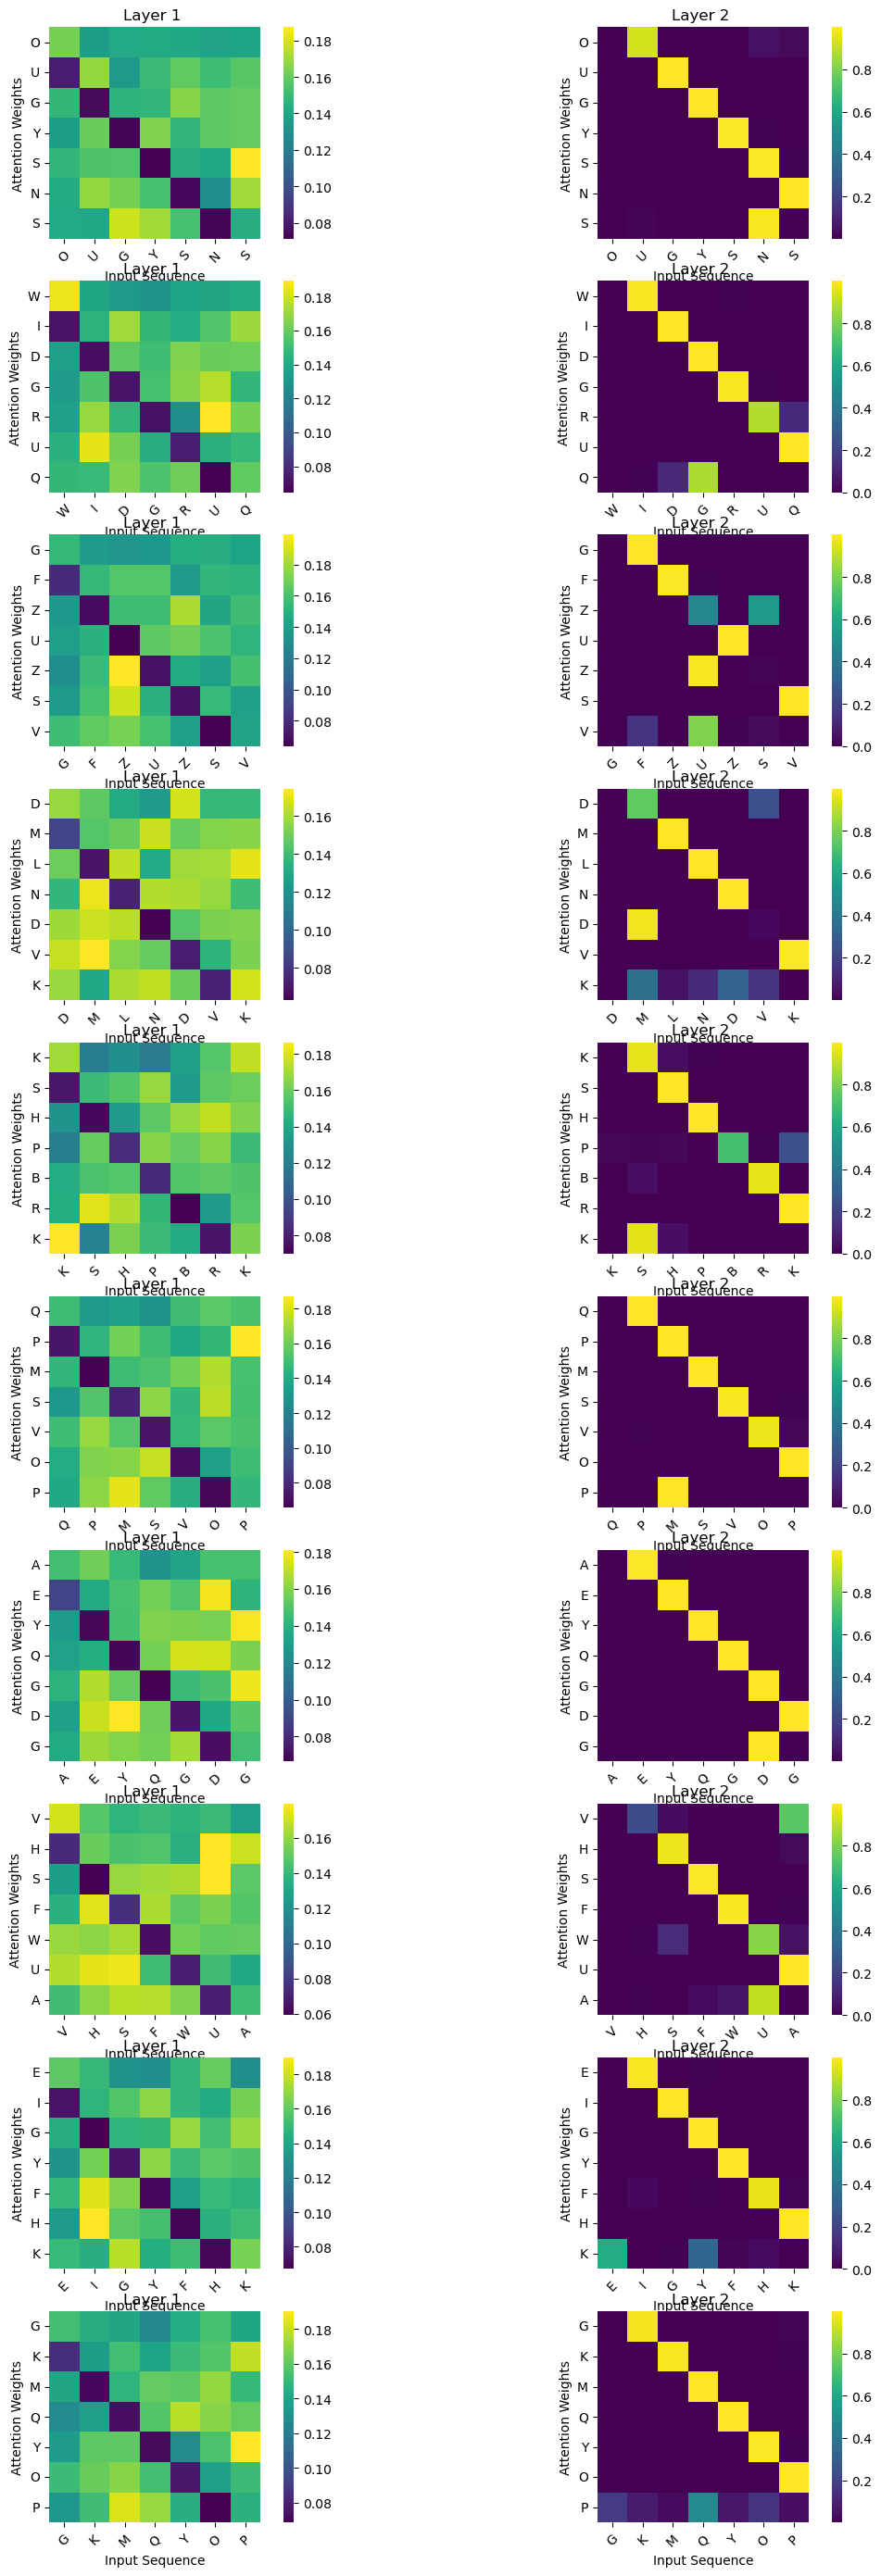

In [745]:
def plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char):
    model.eval()
    num_sequences = len(X_plot) 
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))
    with torch.no_grad():

        for i in range(len(X_plot)):
            attn_weights = []
            x = X_plot[i:i+1]
            print(f"len:{len(x[0])}")
            y = y_plot[i:i+1]

            logits = model(x)
            pred_idx = logits.argmax(dim=1).item()
            pred_letter = int_to_char[pred_idx+1]
            true_letter = int_to_char[y.item()+1]

            print(f"Sequence : {X_seq[i]}")
            print(f"  True : {true_letter}, Predicted : {pred_letter}")
            
            for j in range(len(model.blocks)):
                attn_weights.append(model.blocks[j].attn_weights)

            for j, attn in enumerate(attn_weights):
                print(i,j)
                sns.heatmap(attn[0].cpu().numpy(), cmap="viridis",
                            xticklabels=X_seq[i][begin:],
                            yticklabels=X_seq[i][begin:], ax=axs[i, j],
                            square=True)
                axs[i][j].set_title(f"Layer {j + 1} ")
                axs[i][j].set_xlabel("Input Sequence")
                axs[i][j].set_ylabel("Attention Weights")
                axs[i][j].set_xticklabels(X_seq[i][begin:], rotation=45)
                axs[i][j].set_yticklabels(X_seq[i][begin:], rotation=0)
    return fig

fig = plot_attention_matrix(model, X_plot, y_plot, char_to_int, int_to_char)

In [ ]:
fig.savefig("subdiagonal_without_attention_len11.png", dpi=300, bbox_inches='tight')

In [ ]:
# k-composition
import torch
import torch.nn.functional as F

# Charger le modèle
model = model_saved
model.eval()

# Récupération des matrices
block1 = model.blocks[0]
block2 = model.blocks[1]

Wq1 = block1.Wq.weight  # (d_model, d_model)
Wv1 = block1.Wv.weight  # (d_model, d_model)
Wq2 = block2.Wq.weight
Wk2 = block2.Wk.weight

# Construire W_OV^(1) = Wv1
W_OV_1 = Wv1  # approximation car pas de W_O séparé

# Construire W_QK^(2) = Wk2 @ Wq2
W_QK_2 = Wk2 @ Wq2  # (d_model, d_model)

# Norme de Frobenius des matrices
numerator = torch.norm(W_QK_2 @ W_OV_1, p='fro')
denominator = torch.norm(W_QK_2, p='fro') * torch.norm(W_OV_1, p='fro')

# K-Composition
k_composition = (numerator / denominator).item()
print(f"K-Composition (Layer 2 K * Layer 1 V): {k_composition:.4f}")


K-Composition (Layer 2 K * Layer 1 V): 0.0632


In [ ]:
import torch
import torch.nn.functional as F

# Charger le modèle
model = model_saved
model.eval()

# Récupération des deux blocs
block1 = model.blocks[0]
block2 = model.blocks[1]

# Extraire les matrices
Wq1 = block1.Wq.weight  # (d_model, d_model)
Wk1 = block1.Wk.weight
Wv1 = block1.Wv.weight

Wq2 = block2.Wq.weight
Wk2 = block2.Wk.weight
Wv2 = block2.Wv.weight

# W_OV = Wv (pas de W_o dans ce modèle)
W_OV_1 = Wv1
W_OV_2 = Wv2

# W_QK = Wk @ Wq
W_QK_2 = Wk2 @ Wq2

# K-Composition
kcomp_num = torch.norm(W_QK_2 @ W_OV_1, p='fro')
kcomp_den = torch.norm(W_QK_2, p='fro') * torch.norm(W_OV_1, p='fro')
k_comp = (kcomp_num / kcomp_den).item()

# Q-Composition
qcomp_num = torch.norm(W_QK_2.T @ W_OV_1, p='fro')
qcomp_den = torch.norm(W_QK_2, p='fro') * torch.norm(W_OV_1, p='fro')
q_comp = (qcomp_num / qcomp_den).item()

# V-Composition
vcomp_num = torch.norm(W_OV_2 @ W_OV_1, p='fro')
vcomp_den = torch.norm(W_OV_2, p='fro') * torch.norm(W_OV_1, p='fro')
v_comp = (vcomp_num / vcomp_den).item()

# Affichage
print(f"K-Composition (Layer 2 K * Layer 1 V) : {k_comp:.4f}")
print(f"Q-Composition (Layer 2 Q * Layer 1 V) : {q_comp:.4f}")
print(f"V-Composition (Layer 2 V * Layer 1 V) : {v_comp:.4f}")


K-Composition (Layer 2 K * Layer 1 V) : 0.0632
Q-Composition (Layer 2 Q * Layer 1 V) : 0.0632
V-Composition (Layer 2 V * Layer 1 V) : 0.0632


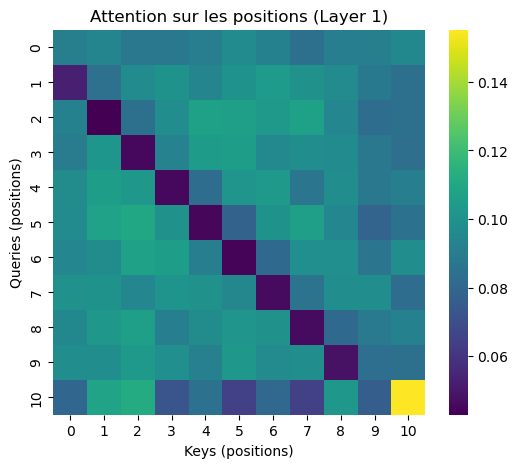

In [747]:
import torch

# Dimensions
T = 11  # longueur de séquence
device = torch.device("cpu")  # ou "cuda" si dispo

model.eval()

# Donnée sans contenu (embedding nul)
x_dummy = torch.zeros(1, T, model.positional_encoding.size(-1)).to(device)

# Ajouter uniquement l'encodage positionnel
x_pos = x_dummy + model.positional_encoding[:, :T, :]

# Propagation dans une couche
with torch.no_grad():
    out = model.blocks[0](x_pos)
    attn_matrix = model.blocks[0].attn_weights.squeeze(0)  # (T, T)

# Affichage basique ou impression
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(attn_matrix.numpy(), cmap="viridis", xticklabels=True, yticklabels=True)
plt.title("Attention sur les positions (Layer 1)")
plt.xlabel("Keys (positions)")
plt.ylabel("Queries (positions)")
plt.show()
